 “The band-specific oversubtraction factor αi is a function of the segmental SNRi of the ith frequency band and is computed as follows” ([Loizou, p. 117](zotero://select/library/items/IBKAK3L2)) ([pdf](zotero://open-pdf/library/items/YVIX94UY?page=145&annotation=5W6KZ45V))

 Upadhyay and Karmakar, “Speech Enhancement Using Spectral Subtraction-Type Algorithms.” 
 
 All-Pole Modeling of Degraded Speech

  References: [1] Hu, Y. and Loizou, P. (2004). Speech enhancement based on wavelet 
      thresholding the multitaper spectrum. IEEE Trans. on Speech and Audio 
      Processing, 12(1), 59-67.
  
Authors: Yi Hu and Philipos C. Loizou

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

# input wave file 
f1 = "C:\\Users\\Julio\\Documents\\Projects\\audio-denoiser\\data\\test.wav"
x, sr = librosa.load(f1, sr=16000)

# calculation parameters
n_fft = 512     # frame size in samples

hop = int(.5*n_fft)         # hop size in samples
hop = hop 

X = librosa.stft(x, n_fft=n_fft, hop_length=hop)

# setting default parameters
vad_db = 5       # VAD vad_dbhold in dB SNRseg
gamma = 1.0     # exp(gamma)
G = .6 #smoothing factor


nFFT = 512
noise_mean = np.zeros((nFFT//2+1))
for k in range(0, 5):
    noise_mean = noise_mean + abs(X[:, k])
    
# noise estimate from first 5 frames
noise_mu = noise_mean / 5

# initialize various variables
img = 1j
X_out = np.zeros(X.shape, dtype=complex)

# main processing loop
for n in range(0, X.shape[1]):
    # extract a frame
    signal_spec = X[:, n]
    # compute the magnitude
    signal_magnitude = abs(signal_spec)
    # save the noisy phase information
    theta = np.angle(signal_spec)
    #  compute segmental SNR for VAD
    SNRseg = 10 * np.log10(np.linalg.norm(signal_magnitude, 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)
    
    # perform the spectral subtraction
    clean_signal_magnitude = signal_magnitude ** gamma - noise_mu ** gamma

    # halfwave rectification (zero out negative values)
    clean_signal_magnitude = np.maximum(clean_signal_magnitude, 0)
    
    # compute a Priori SNR (used)
    SNRpri = 10 * np.log10(np.linalg.norm(clean_signal_magnitude, 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)
    
    # parameter band dependent oversubtraction factor
    mu_max = 20
    mu_to_plus, mu_to_min = 1, mu_max
    mu_slope = ((mu_to_min - mu_to_plus) * mu_max) / 25
    mu_0 = mu_to_plus + 20*mu_slope
    def get_alpha(SNR):
        if SNR >= 20:
             return mu_to_plus
        elif -5.0 <= SNR <= 20.0:
            return mu_0 - SNR*mu_slope
        else: return mu_to_min
    alpha = get_alpha(SNRpri) 

    # 2 gain function G
    G_i = clean_signal_magnitude ** 2 / (clean_signal_magnitude ** 2 + alpha * noise_mu ** 2)
    wf_speech = G_i * signal_magnitude
    
    # --- implement a simple VAD detector --- #
    if SNRseg < vad_db:  # Update noise spectrum
        noise_temp = G * noise_mu ** gamma + (1 - G) * signal_magnitude ** gamma  # noise power spectrum smoothing
        noise_mu = noise_temp ** (1 / gamma)  # New noise amplitude spectrum
        clean_signal_magnitude = .2*signal_magnitude  # suppress the signal

    
    # add phase    
    phased_clean_signal = (wf_speech ** (1 / gamma)) * np.exp(img * theta)       
    # store the output
    X_out[:, n] = phased_clean_signal

x_out = librosa.istft(X_out, hop_length=hop, n_fft=nFFT)

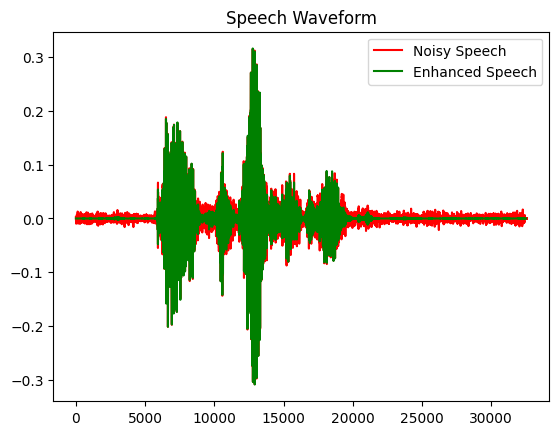

In [5]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
testfile ="C:\\Users\\Julio\\Documents\\Projects\\audio-denoiser\\data\\test.wav"
x, sr = librosa.load(testfile, sr=16000)
n_fft = 512
hop = int(.5*n_fft)
X = librosa.stft(x, n_fft=n_fft, hop_length=hop)
# clean_signal = apply_iterative_wiener(x, frame_len=n_fft, lpc_order=20, iterations=6, alpha=1, thresh=.05)
plt.plot(x, 'red')
plt.plot(x_out, "green")
plt.title('Speech Waveform')
plt.legend(['Noisy Speech', 'Enhanced Speech'])
ipd.Audio(x_out, rate=sr)

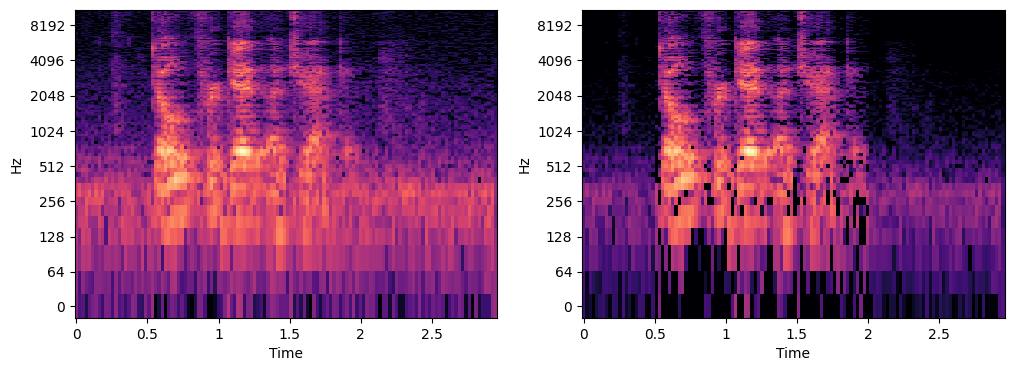

In [4]:
import librosa.display
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(abs(X), ref=np.max), y_axis='log', x_axis='time')
plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(abs(X_out), ref=np.max), y_axis='log', x_axis='time')